In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def filter_image(input, filter):
    """
    Return the convolution result: image * kernel.
    Caution: use zero-padding.

    Input- image: H x W
           filter: h x w
    Output- convolve: H x W
    """
    input=input.astype(np.float64)

    H,W =input.shape
    h,w =filter.shape

    #padding calculation
    pad_h=h//2
    pad_w=w//2

    #zero-padding the input image
    pad_input=np.pad(input,((pad_h,pad_h),(pad_w,pad_w)), mode='constant')

    output=np.zeros((H,W), dtype=np.float64)

    #CONVOLUTION
    for i in range(H):
      for j in range(W):
         region=pad_input[i:i+h,j:j+w]
         output[i,j]=np.sum(region * filter)

    return output


In [3]:
def sobel_operator(image):
    """
    Return Gx, Gy, and the gradient magnitude.

    Input- image: H x W
    Output- Gx, Gy, grad_magnitude: H x W
    """
    # TODO: Use filter_image() to complete the function

    sobel_x=np.array([[-1,0,1],
                      [-2,0,2],
                      [-1,0,1]],dtype=np.float64)
    sobel_y=np.array([[-1,-2,-1],
                      [0,0,0],
                      [1,2,1]],dtype=np.float64)

    #using filter_image to apply the filters
    Gx, Gy = filter_image(image,sobel_x), filter_image(image,sobel_y)
    grad_magnitude = np.sqrt(Gx**2 + Gy**2)

    return Gx, Gy, grad_magnitude

In [4]:
def generate_gaussian(sigma):
    """
    Return kernel of appropriate size
    Caution: coefficients must sum to 1

    Input- sigma: scalar (should be positive but it will be squared anyway)
    Output- kernel: W x W (no need to return W)
    """
    #kernel size
    size=int(6*sigma +1)
    if size%2==0:
      size+=1

    #coordinate grid
    center=size//2
    kernel=np.zeros((size,size))

    #generate gaussian kernel
    for i in range(size):
      for j in range(size):
        x=i-center
        y=j-center
        kernel[i,j]=np.exp(-(x**2 + y**2)/(2* sigma**2))

    #normalizing
    kernel = kernel/np.sum(kernel)

    return kernel


In [5]:
def harris_detector(image, window_size=5):
    """
    Given an input image, calculate the Harris Detector score for all pixels
    Use zero-padding to handle boundaries

    Input- image: H x W
    Output- results: a image of size H x W
    """
    # compute the derivatives
    Ix, Iy, _ = sobel_operator(image)

    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    #box filter for windowing
    box_filter=np.ones((window_size,window_size),dtype=np.float64)/(window_size*window_size)
    Sxx=filter_image(Ixx, box_filter)
    Syy=filter_image(Iyy, box_filter)
    Sxy=filter_image(Ixy, box_filter)



    # For each image location, construct the structure tensor and calculate
    # the Harris response

    k=0.04 #Harris corner detection constant

    det_m=Sxx * Syy - Sxy * Sxy
    trace_m=Sxx + Syy
    response = det_m - k * (trace_m ** 2)

    return response

In [6]:
def nms(input):
    """
    Non-max suppression in 3x3 windows.
    Use zero-padding.

    Input- image: H x W
    Output- nms_image: H x W
    """

    H,W=input.shape
    nms_image = np.zeros((H,W),dtype=np.float64)

    #padding input with zeros
    pad_input=np.pad(input,((1,1),(1,1)),mode='constant',constant_values=0)

    #local maxima in 3x3 neigborhoods
    for i in range(H):
      for j in range(W):
        #extract 3x3 neigborhood
        ngh=pad_input[i:i+3,j:j+3]
        center_val=input[i,j]

        #checking whether center_val is max and positive in ngh
        if center_val==np.max(ngh) and center_val>0:
          nms_image[i,j]=center_val

    return nms_image


In [7]:
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

In [24]:
def main():
  from google.colab import drive
  #drive.mount('/content/gdrive', force_remount=True)
  rootpath = '/content'
  input_image = cv2.imread(os.path.join(rootpath, "skyline.jpg"))
  input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
  imshow(input_image)

  # Step 1
  # Sobel filter
  Gx, Gy, grad_mag  = sobel_operator(input_image)
  print('\nAbsolute values of the response to the horizontal and vertical Sobel filters')
  # display

  #sobel_operator output normalization
  Gx_display = np.abs(Gx)
  Gx_display = (Gx_display / Gx_display.max() * 255).astype(np.uint8)
  imshow(Gx_display)

  Gy_display = np.abs(Gy)
  Gy_display = (Gy_display / Gy_display.max() * 255).astype(np.uint8)
  imshow(Gy_display)

  # Step 2
  # Gaussian filter
  sigma = 2.0
  kernel = generate_gaussian(sigma)
  print('\nKernel for sigma = ' + repr(sigma))
  #normalizing kernel
  kernel_normal=((kernel - kernel.min())/(kernel.max()-kernel.min())* 255).astype(np.uint8)
  imshow(kernel_normal)

  image_gauss = filter_image(input_image, kernel)
  print('\nImage after Gaussian filtering')
  image_gauss_display = np.clip(image_gauss, 0, 255).astype(np.uint8)
  imshow(image_gauss_display)
  # display

  # Step 3
  # smooth and compute derivatives
  print('\nEdge gradient magnitude after Gaussian filtering')
  Gx_smooth, Gy_smooth, grad_mag_smooth = sobel_operator(image_gauss)
  grad_normal = np.clip(grad_mag_smooth, 0, 255).astype(np.uint8)
  imshow(grad_normal)
  # display only final output - we have already seen intermediate results

  # Step 4
  # Harris operator
  winsize = 5
  harris_resp = harris_detector(input_image, winsize)
  print('\nMagnitude of Harris operator')
  #normalize harris response
  harris_normal=np.abs(harris_resp)
  if harris_normal.max() > 0:
        harris_normal = (harris_normal / harris_normal.max() * 255).astype(np.uint8)
  else:
        harris_normal = harris_normal.astype(np.uint8)
  imshow(harris_normal)


  # display only final output - we have already seen intermediate results

  # Step 5
  # NMS
  image_nms = nms(harris_resp)
  # Thresholding and super-imposing corners on input
  # You may implement this here or as separate function(s)
  #print('Corner locations after thresholding')
  # display
  #print('Corners superimposed on input image')
  # display
  # Thresholding - aim for 100-300 corners
  non_zero_values = image_nms[image_nms > 0]
  if len(non_zero_values) > 0:
        sorted_values = np.sort(non_zero_values)[::-1]
        num_corners_target = 200
        n_corners = min(num_corners_target, len(sorted_values))
        threshold = sorted_values[n_corners-1] if n_corners < len(sorted_values) else sorted_values[-1]

        #binary corner image
        corners_binary = (image_nms >= threshold).astype(np.uint8) * 255

        print(f'Corner locations after thresholding (detected {n_corners} corners)')
        imshow(corners_binary)

        #overlay corners on original
        overlay = np.stack([input_image, input_image, input_image], axis=2)
        corner_locations = np.where(image_nms >= threshold)

        for y, x in zip(corner_locations[0], corner_locations[1]):
            if 1 < y < input_image.shape[0]-2 and 1 < x < input_image.shape[1]-2:
                overlay[y-1:y+2, x, 0] = 255
                overlay[y, x-1:x+2, 0] = 255
                overlay[y-1:y+2, x, 1] = 0
                overlay[y, x-1:x+2, 1] = 0
                overlay[y-1:y+2, x, 2] = 0
                overlay[y, x-1:x+2, 2] = 0

        print('Corners superimposed on input image')
        imshow(overlay)
  else:
        print('No corners detected!')


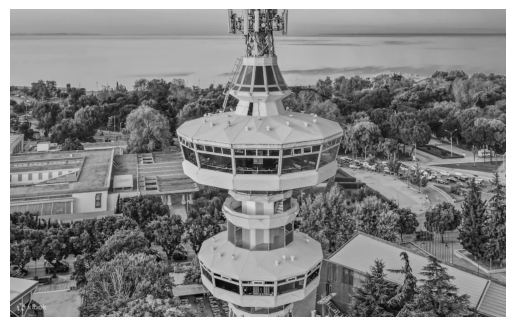


Absolute values of the response to the horizontal and vertical Sobel filters


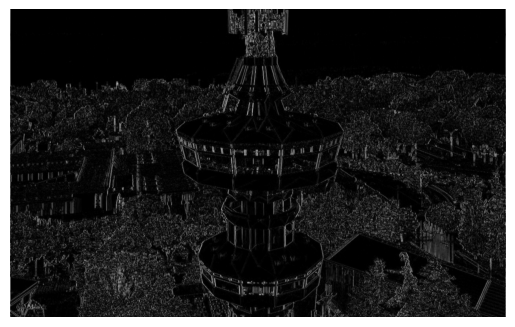

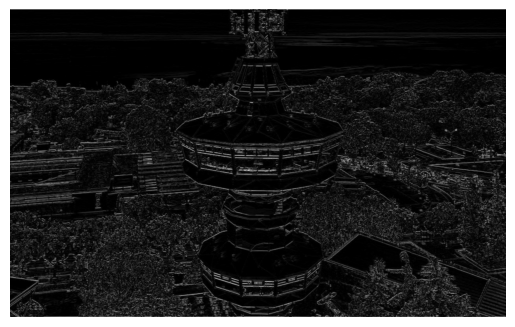


Kernel for sigma = 2.0


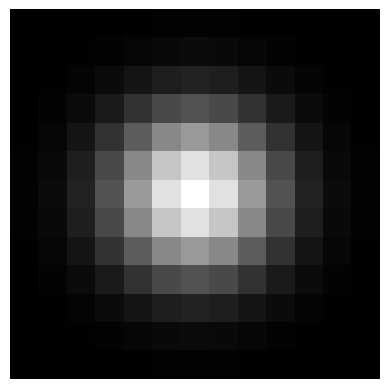


Image after Gaussian filtering


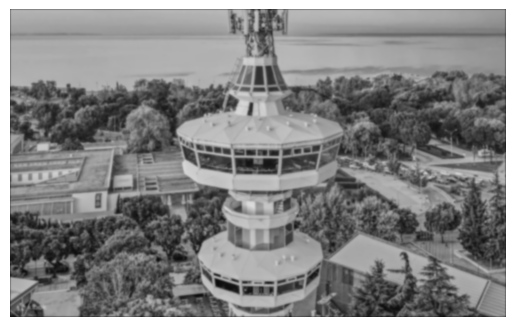


Edge gradient magnitude after Gaussian filtering


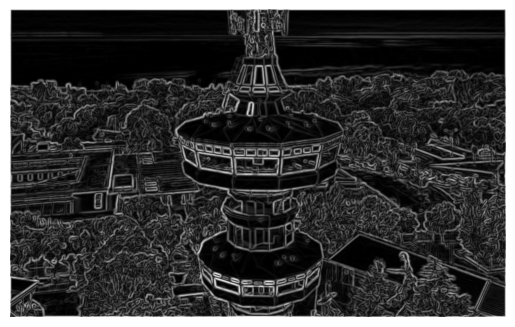


Magnitude of Harris operator


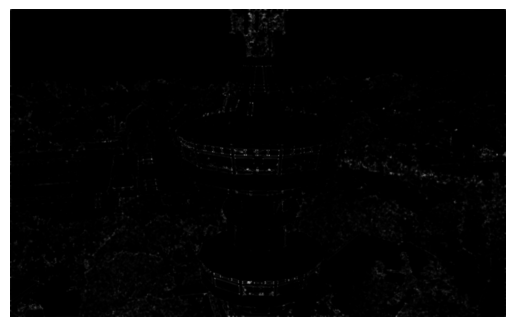

Corner locations after thresholding (detected 200 corners)


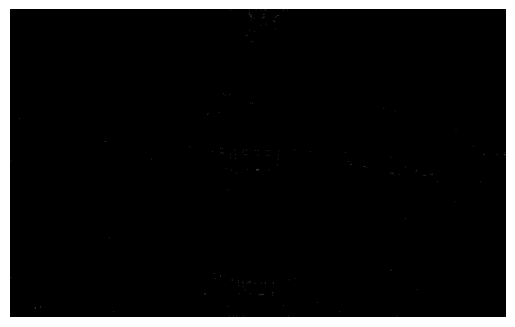

Corners superimposed on input image


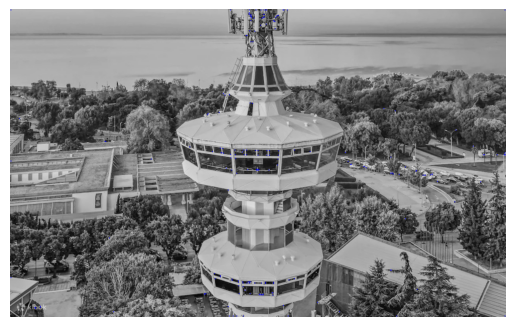

In [25]:
main()